# Dogs vs. Cats
Given a dataset of images obtained from kaggle [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) containing both cats and dogs, develop a machine learning model that classifies each image into one of two categories: 'Cat' or 'Dog'? 

**Task**: create a classification model that can differentiate between these two common household pets based on the visual features present in the images. The accuracy of the model's predictions will be the key metric to evaluate its performance.

## Install `tensorflow` and check version

In [ ]:
! pip install tensorflow
import tensorflow as tf
print(tf.__version__)

## Prepare Data

### Manually upload the train.zip file from Kaggle
 - This is required as one needs to log into `Kaggle` to download the data
 - Only the 'train.zip' file is used in this program which in itself contains `25,000` images of dogs and cats
 - Out of the 25k image we take 1000 images each of dogs and cats for training and 400 each for testing, rest of the images are not used

In [ ]:
# check post uploading the file
!ls -al train*

### Extract the zip file
- The resulting file generates a directory called 'train.'
- Within this directory, there are 12,500 cat images and an equal quantity of dog images.

In [37]:
# unzip the file
!unzip -q train.zip


In [129]:
# inspect the files
import subprocess

# prepare shell commands to count dog and cat images
count_dogs_cmd = "ls train/dog* -1 | wc -l"
count_cats_cmd = "ls train/cat* -1 | wc -l"

print('No of dog images: ' + subprocess.getoutput(count_dogs_cmd))
print('No of cat images: ' + subprocess.getoutput(count_cats_cmd))




No of dog images: 12100
No of cat images: 12100


### Split data into `train` and `test`
- Establish the following directory structure:
  - `data/train/cats`
  - `data/train/dogs`
  - `data/test/cats`
  - `data/test/dogs`

- Move 1000 cat images from the "train" folder to the "data/train/cats" directory.
- Move 1000 dog images from the "train" folder to the "data/train/cats" directory.

- Move 400 cat images from the "train" folder to the "data/test/cats" directory.
- Move 400 dog images from the "train" folder to the "data/test/cats" directory.

* Create directory structure

In [126]:
# Create necessary directories
!mkdir -p data/train/cats
!mkdir -p data/train/dogs
!mkdir -p data/test/cats
!mkdir -p data/test/dogs


In [128]:
# Move 400 cat images from train to data/test/cats
!find train -type f -name "cat*.jpg" | head -n 400 | xargs -I {} mv {} data/test/cats/

# Move 400 dog images from train to data/test/dogs
!find train -type f -name "dog*.jpg" | head -n 400 | xargs -I {} mv {} data/test/dogs/

find: ‘standard output’: Broken pipe
find: write error
find: ‘standard output’: Broken pipe
find: write error


In [130]:
# Move 1000 cat images from train to data/train/cats
!find train -type f -name "cat*.jpg" | head -n 1000 | xargs -I {} mv {} data/train/cats/

# Move 1000 dog images from train to data/train/dogs
!find train -type f -name "dog*.jpg" | head -n 1000 | xargs -I {} mv {} data/train/dogs/



find: ‘standard output’: Broken pipe
find: write error
find: ‘standard output’: Broken pipe
find: write error


In [ ]:
!ls data/test/cats

In [134]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

def display_images(file_list, columns=5, figure_size=(12, 12)):
    num_images = len(file_list)
    
    # Calculate the number of rows needed to display the images
    rows = int(math.ceil(num_images / columns))
    
    # Create a figure with the specified size
    plt.figure(figsize=figure_size)
    
    for i, filename in enumerate(file_list):
        # Create each subplot and set the size
        plt.subplot(rows, columns, i + 1)
        plt.title(os.path.basename(filename))
        image = mpimg.imread(filename)
        
        # Set the size of the individual subplots
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels and ticks

    plt.tight_layout()  # Automatically adjust subplot parameters for a better layout
    plt.show()


In [135]:
import os

def list_files_in_directory(directory_path):
    full_paths = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, file))]
    return full_paths


In [140]:
train_cats_dir = 'data/train/cats'
train_dogs_dir = 'data/train/dogs'
test_cats_dir = 'data/test/cats'
test_dogs_dir= 'data/test/dogs'


train_cat_files = list_files_in_directory(train_cats_dir)
train_dog_files = list_files_in_directory(train_dogs_dir)
test_cat_files = list_files_in_directory(test_cats_dir)
test_dog_files = list_files_in_directory(test_dogs_dir)

First 25 cat files for training: 



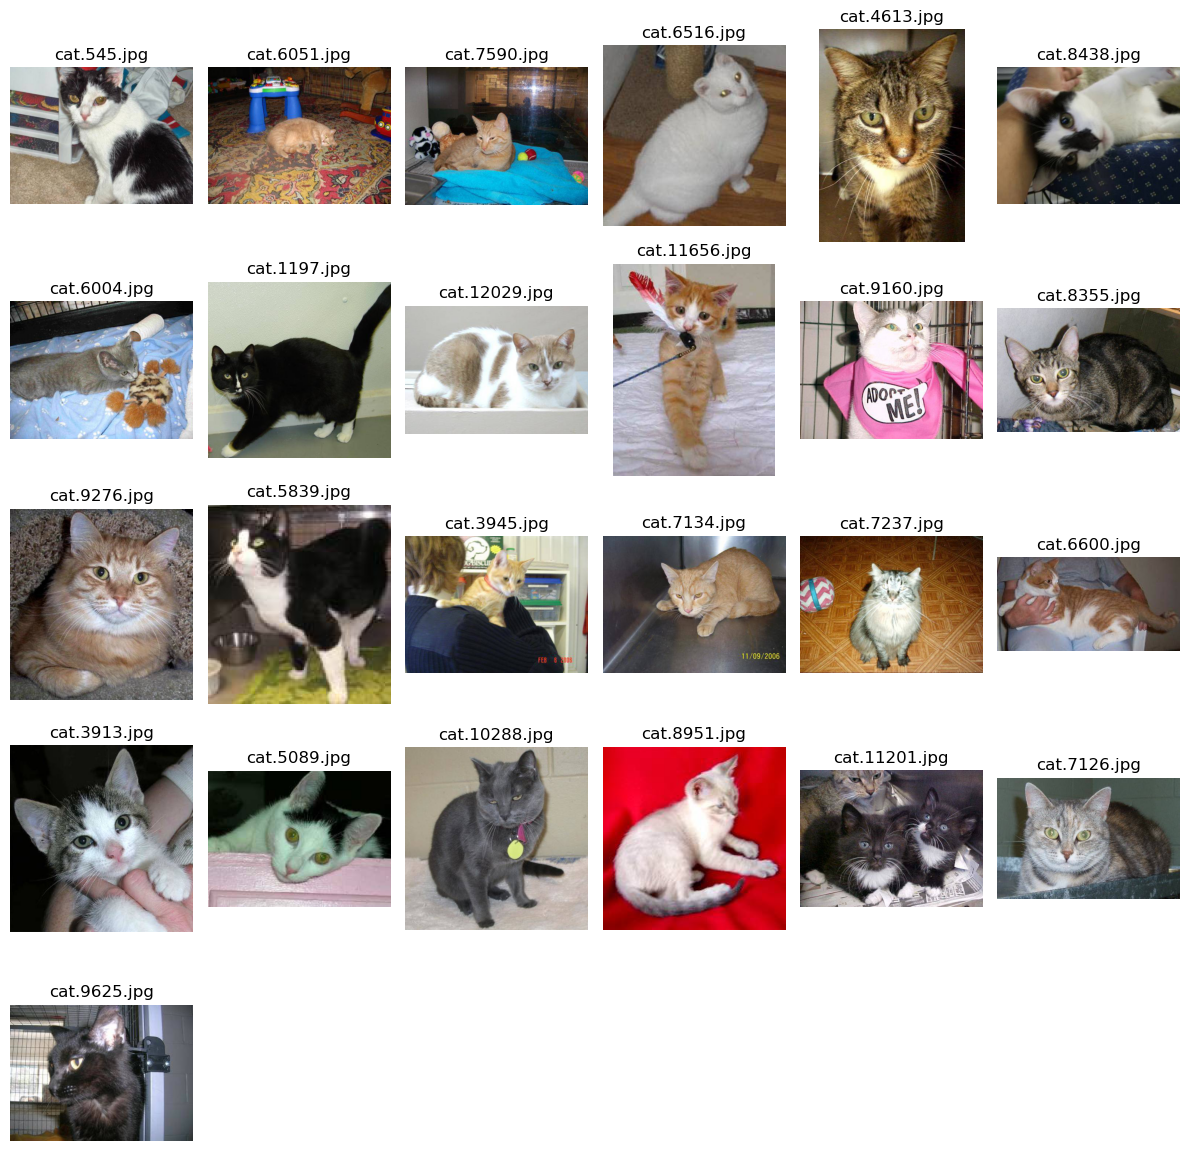

First 25 dog files for training: 



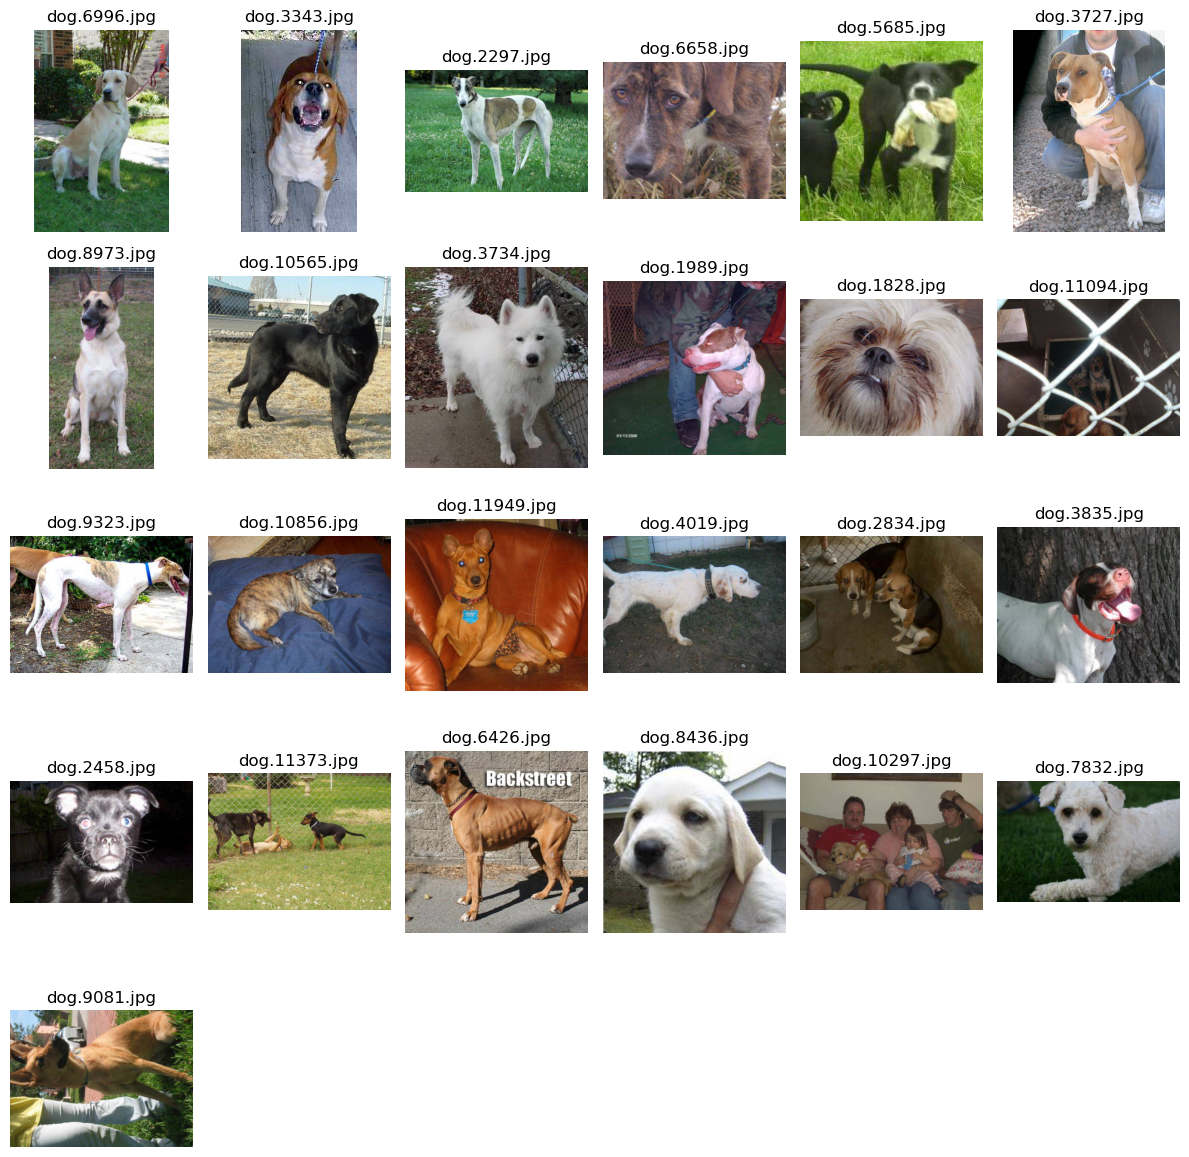

In [142]:
print('First 25 cat files for training: \n')
display_images(train_cat_files[:25],6)

print('First 25 dog files for training: \n')
display_images(train_dog_files[:25],6)

In [203]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define data directories
train_data_dir = 'data/train'
test_data_dir = 'data/test'

# Set the image size according to InceptionV3's input size
img_width, img_height = 299, 299
batch_size = 32

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale for test images (no augmentation)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers on top of the pre-trained model for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=5, steps_per_epoch=len(train_generator), validation_data=test_generator, validation_steps=len(test_generator))


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/5


2023-10-22 00:57:09.667523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-22 00:57:15.619430: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:274] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-10-22 00:57:15.620138: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:362 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-10-22 00:57:15.620206: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]]


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_118/3309940153.py", line 61, in <module>
      model.fit(train_generator, epochs=5, steps_per_epoch=len(train_generator), validation_data=test_generator, validation_steps=len(test_generator))
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_61538]

In [200]:
import glob
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D

In [150]:
# Get count of number of files in this folder and all subfolders
def get_num_files(path):
  if not os.path.exists(path):
    return 0
  return sum([len(files) for r, d, files in os.walk(path)])

In [149]:
# Get count of number of subfolders directly below the folder in path
def get_num_subfolders(path):
  if not os.path.exists(path):
    return 0
  return sum([len(d) for r, d, files in os.walk(path)])

In [163]:
# Create image generators to generate image variations by applying transformations such as rotation, vertical and horizontal shifting, shearing, zooming, and horizontal flipping.
def create_img_generator():
  return  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

In [165]:
# Main Code
Image_width, Image_height = 299, 299 
Training_Epochs = 2
Batch_Size = 32
Number_FC_Neurons = 1024

train_dir = './data/train'
test_dir = './data/test'
num_train_samples = get_num_files(train_dir) 
num_classes = get_num_subfolders(train_dir)
num_test_samples = get_num_files(test_dir)
num_epoch = Training_Epochs
batch_size = Batch_Size

In [168]:
print('train samples: ' + str(num_train_samples))
print('num_classes:'  + str(num_classes))
print('num_test_samples: '  + str(num_test_samples))

train samples: 2000
num_classes:2
num_test_samples: 800


In [169]:
# Define data pre-processing 
#   Define image generators for training and testing 
train_image_gen = create_img_generator()
test_image_gen = create_img_generator()

In [172]:
#   Connect the image generator to a folder contains the source images the image generator alters.  
#   Training image generator
train_generator = train_image_gen.flow_from_directory(
  train_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed = 42    #set seed for reproducability
)

#   test image generator
test_generator = test_image_gen.flow_from_directory(
  test_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed=42       #set seed for reproducability
)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [180]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [179]:
type(train_generator)

keras.preprocessing.image.DirectoryIterator

In [202]:
# Load the Inception V3 model and load it with it's pre-trained weights.  But exclude the final 
#    Fully Connected layer
InceptionV3_base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
print('Inception v3 base model without last FC loaded')
#print(InceptionV3_base_model.summary())     # display the Inception V3 model hierarchy

# Define the layers in the new classification prediction 
#x = InceptionV3_base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dense(Number_FC_Neurons, activation='relu')(x)        # new FC layer, random init
#predictions = Dense(num_classes, activation='softmax')(x)  # new softmax layer

model=Sequential()
model.add(InceptionV3_base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(Number_FC_Neurons, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


Inception v3 base model without last FC loaded


In [ ]:
# Define trainable model which links input from the Inception V3 base model to the new classification prediction layers
model = Model(inputs=InceptionV3_base_model.input, outputs=predictions)

# print model structure diagram
print (model.summary())

In [181]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [182]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}

In [196]:
# Option 1: Basic Transfer Learning
print ('\nPerforming Transfer Learning')
  #   Freeze all layers in the Inception V3 base model 
for layer in InceptionV3_base_model.layers:
  layer.trainable = False
#   Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the transfer learning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from 
# the training or validation folders and alter them slightly
history_transfer_learning = model.fit(
  train_generator,
  epochs=num_epoch,
  validation_data=validation_generator)



Performing Transfer Learning
Epoch 1/2


2023-10-22 00:03:32.079443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-22 00:03:37.300357: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:274] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-10-22 00:03:37.300947: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:362 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-10-22 00:03:37.301000: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]]


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_118/745918772.py", line 12, in <module>
      history_transfer_learning = model.fit(
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_20413]

In [ ]:
# Fit the transfer learning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from 
# the training or validation folders and alter them slightly

history_transfer_learning = model.fit(
train_generator,
  epochs=num_epoch,
  steps_per_epoch = num_train_samples,
  validation_data=validation_generator)